# Install Library

[RDKit ](https://github.com/rdkit/rdkit)

[DGL](https://github.com/dmlc/dgl/)

[DGL-LifeSci](https://github.com/awslabs/dgl-lifesci)





In [ ]:
!pip install --pre dgl -f https://data.dgl.ai/wheels/cu113/repo.html
!pip install --pre dglgo -f https://data.dgl.ai/wheels-test/repo.html

In [ ]:
%%capture
!pip install rdkit-pypi
!pip install dgllife

# Import Library

In [14]:
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES']='-1'
os.environ['TF_CUDNN_USE_AUTOTUNE'] ='0'

import dgl 
import sys
import torch
import random
import statistics
import cv2
import torchvision
import pandas as pd
import numpy as np
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

from numpy import array
from numpy import argmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import  History
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, AttentiveFPAtomFeaturizer
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split
from dgllife.model import MLPPredictor

from utils.general import DATASET, get_dataset, separate_active_and_inactive_data, get_embedding_vector_class, count_lablel,data_generator
from utils.gcn_pre_trained import get_sider_model

from model.heterogeneous_siamese_sider import siamese_model_attentiveFp_sider, siamese_model_Canonical_sider


random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [15]:
cache_path='./sider_dglgraph.bin'

df = get_dataset("sider")

In [16]:
sider_tasks = df.columns.values[1:].tolist()
sider_tasks_test = sider_tasks[21:28]
train_task, valid_task= train_test_split(sider_tasks, test_size=0.2 , shuffle= False)

In [17]:
from collections import Counter

one = []
zero = []

for task in sider_tasks:
  data = df[task]
  print(task ,":" ,Counter(data))
  zero.append(Counter(data)[0])
  one.append(Counter(data)[1])

Hepatobiliary disorders : Counter({1: 743, 0: 684})
Metabolism and nutrition disorders : Counter({1: 996, 0: 431})
Product issues : Counter({0: 1405, 1: 22})
Eye disorders : Counter({1: 876, 0: 551})
Investigations : Counter({1: 1151, 0: 276})
Musculoskeletal and connective tissue disorders : Counter({1: 997, 0: 430})
Gastrointestinal disorders : Counter({1: 1298, 0: 129})
Social circumstances : Counter({0: 1176, 1: 251})
Immune system disorders : Counter({1: 1024, 0: 403})
Reproductive system and breast disorders : Counter({1: 727, 0: 700})
Neoplasms benign, malignant and unspecified (incl cysts and polyps) : Counter({0: 1051, 1: 376})
General disorders and administration site conditions : Counter({1: 1292, 0: 135})
Endocrine disorders : Counter({0: 1104, 1: 323})
Surgical and medical procedures : Counter({0: 1214, 1: 213})
Vascular disorders : Counter({1: 1108, 0: 319})
Blood and lymphatic system disorders : Counter({1: 885, 0: 542})
Skin and subcutaneous tissue disorders : Counter({

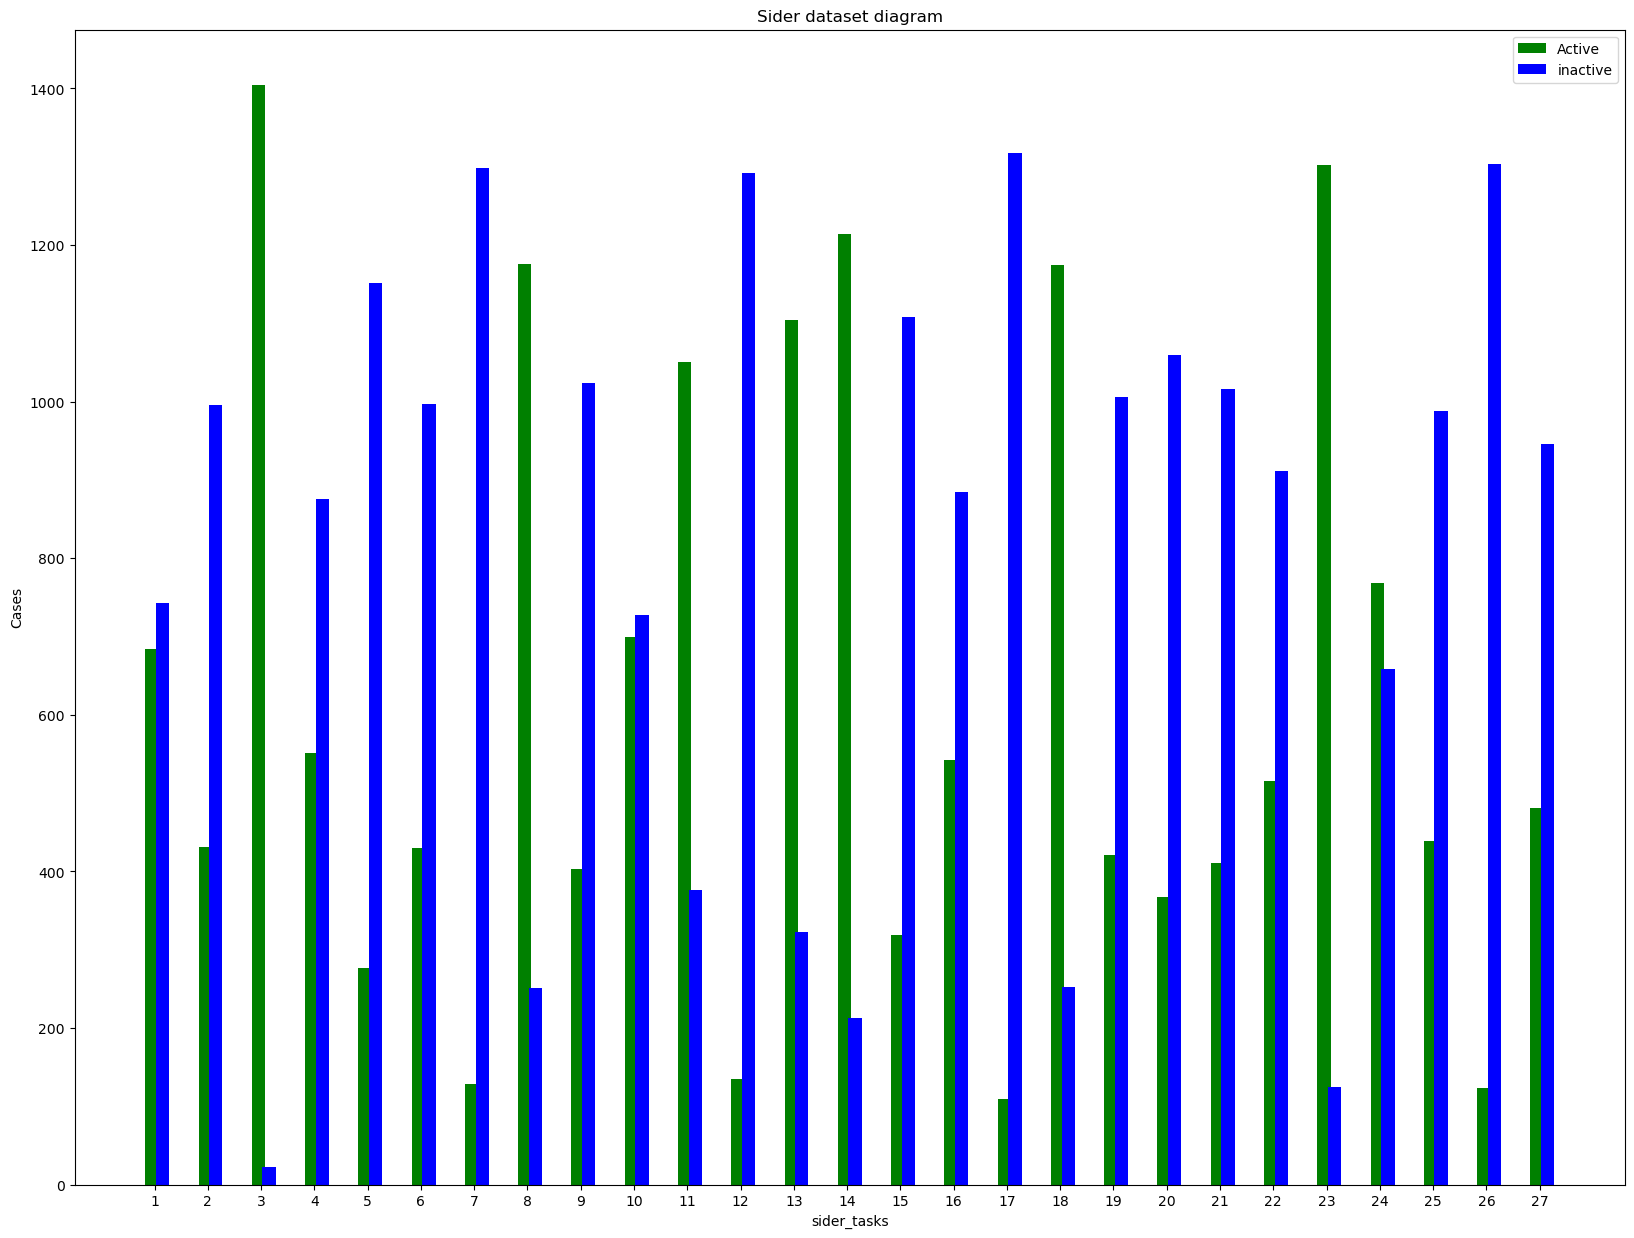

In [18]:
# Importing the matplotlib library
import matplotlib.pyplot as plt
# Declaring the figure or the plot (y, x) or (width, height)
plt.figure(figsize=[20, 15])
# Data to be plotted
X = np.arange(1,len(sider_tasks)+1)

plt.bar(X + 0.20, zero, color = 'g', width = 0.25)
plt.bar(X + 0.4, one, color = 'b', width = 0.25)
# Creating the legend of the bars in the plot
plt.legend(['Active' , 'inactive' ])
# Overiding the x axis with the country names
plt.xticks([i + 0.25 for i in range(1,28)], X)
# Giving the tilte for the plot
plt.title("Sider dataset diagram")
# Namimg the x and y axis
plt.xlabel('sider_tasks')
plt.ylabel('Cases')
# Saving the plot as a 'png'
plt.savefig('4BarPlot.png')
# Displaying the bar plot
plt.show()

# Required functions

In [61]:
from dgllife.model import MLPPredictor

def create_dataset_with_gcn(dataset, class_embed_vector, GCN, tasks ):
    created_data = []
    data = np.arange(len(tasks))
    onehot_encoded = to_categorical(data)
    for i, data in enumerate(dataset):
        smiles, g, labels, mask = data
        g = g.to(device)
        g = dgl.add_self_loop(g)
        graph_feats = g.ndata.pop('h')
        embbed = GCN(g, graph_feats)
        embbed = embbed.to('cpu')
        embbed = embbed.detach().numpy()
        for j, label in enumerate(labels):
            a = (embbed, onehot_encoded[j], class_embed_vector[j], label, tasks[j])
            created_data.append(a)
    print('Data created!!')
    return created_data


def create_meta_data_gcn(GCN, data_train, data_test, class_embed_vector, train_task_size, tasks):
    
    train_data= []
    valid_data = []
    data = np.arange(len(tasks))
    onehot_encoded = to_categorical(data)

    for i, onehot in enumerate(onehot_encoded):

        if i < train_task_size :
            for data in data_train:
                smiles, g, labels, mask = data
                g = g.to(device)
                g = dgl.add_self_loop(g)
                graph_feats = g.ndata.pop('h')
                embbed = GCN(g, graph_feats)
                embbed = embbed.to('cpu')
                embbed = embbed.detach().numpy()
                a = (smiles, embbed, onehot_encoded[i], class_embed_vector[i], labels[i], tasks[i])
                train_data.append(a)
                
        else:
            for data in data_test:
                smiles, g, labels, mask = data
                g = g.to(device)
                g = dgl.add_self_loop(g)
                graph_feats = g.ndata.pop('h')
                embbed = GCN(g, graph_feats)
                embbed = embbed.to('cpu')
                embbed = embbed.detach().numpy()
                a = (smiles, embbed, onehot_encoded[i], class_embed_vector[i], labels[i], tasks[i])
                valid_data.append(a)

    print('Data created!!')            
    return train_data, valid_data   

# Calculation of embedded vectors for each class

In [21]:
df_positive, df_negative = Separate_active_and_inactive_data(df, sider_tasks)

for i,d in enumerate(zip(df_positive,df_negative)):
    print(f'{sider_tasks[i]}=> positive: {len(d[0])} - negative: {len(d[1])}')

Hepatobiliary disorders=> positive: 743 - negative: 684
Metabolism and nutrition disorders=> positive: 996 - negative: 431
Product issues=> positive: 22 - negative: 1405
Eye disorders=> positive: 876 - negative: 551
Investigations=> positive: 1151 - negative: 276
Musculoskeletal and connective tissue disorders=> positive: 997 - negative: 430
Gastrointestinal disorders=> positive: 1298 - negative: 129
Social circumstances=> positive: 251 - negative: 1176
Immune system disorders=> positive: 1024 - negative: 403
Reproductive system and breast disorders=> positive: 727 - negative: 700
Neoplasms benign, malignant and unspecified (incl cysts and polyps)=> positive: 376 - negative: 1051
General disorders and administration site conditions=> positive: 1292 - negative: 135
Endocrine disorders=> positive: 323 - negative: 1104
Surgical and medical procedures=> positive: 213 - negative: 1214
Vascular disorders=> positive: 1108 - negative: 319
Blood and lymphatic system disorders=> positive: 885 - 

In [22]:
dataset_positive = [DATASET(d,smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_positive]
dataset_negative = [DATASET(d,smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_negative]

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1151
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1298
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1024
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1292
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1108
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1318
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1006
Processing dgl graphs from scratch...
Processing molecule 1000/1060


In [23]:
embed_class_sider = get_embedding_vector_class(dataset_positive, dataset_negative, radius=2, size = 512)

class vector created!!


# Bioactivity class-based strategy (Meta-Learning) with BioAct-Het

## Meta-Learning with BioAct-Het and AttentiveFP GCN 


### Siamea model

In [24]:
#  Attentive FP GCN
model_name = 'GCN_attentivefp_SIDER'
gcn_model = get_sider_model(model_name)
gcn_model.eval()
gcn_model = gcn_model.to(device)

Pretrained model loaded


In [25]:
df_all = DATASET(df,smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path)

Processing dgl graphs from scratch...
Processing molecule 1000/1427


In [26]:
train_dataset, valid_dataset = create_meta_data_gcn (gcn_model, df_all, df_all, embed_class_sider, 21, sider_tasks)

Data created!!


In [27]:
print(f'{len(train_dataset)}-{len(valid_dataset)}')

29967-8562


In [28]:
label_pos , label_neg, _ , _  = count_lablel(train_dataset)
print(f'train positive label: {label_pos} - train negative label: {label_neg}')

label_pos , label_neg, _ , _ = count_lablel(valid_dataset)
print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

train positive label: 16935 - train negative label: 13032
Test positive label: 4933 - Test negative label: 3629


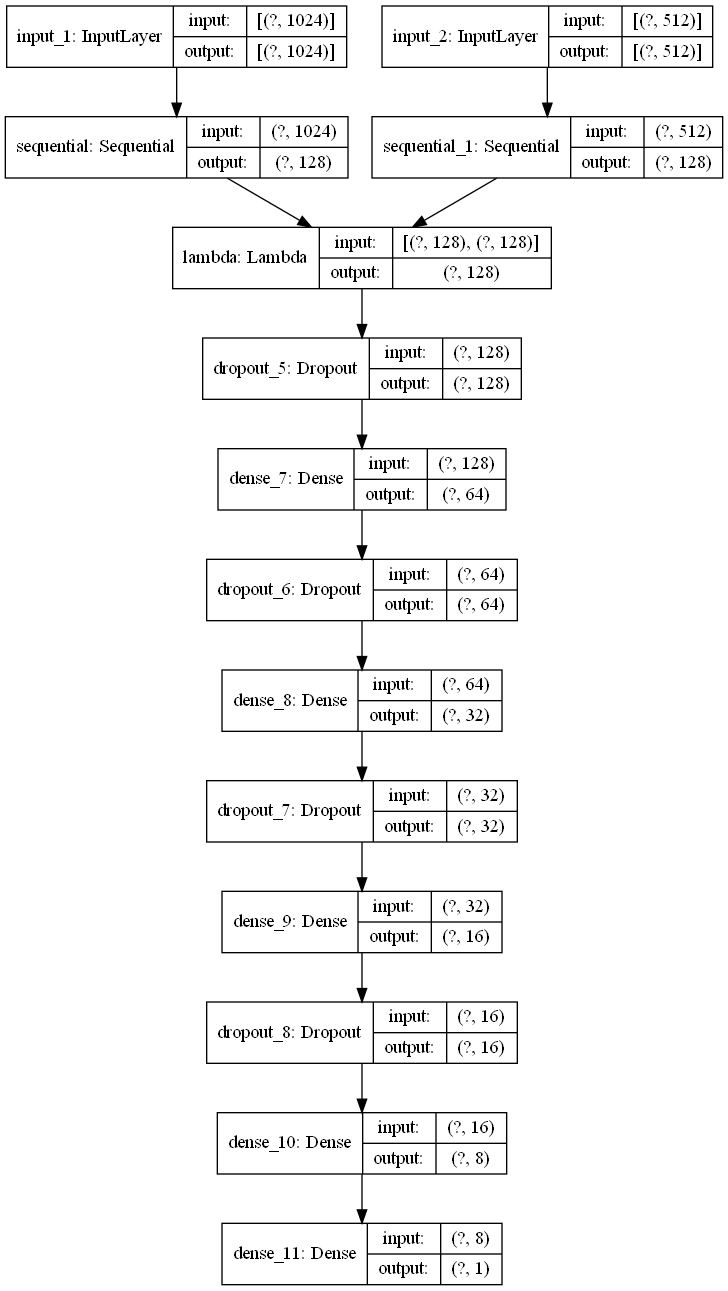

In [29]:
siamese_net = siamese_model_attentiveFp_sider()

plot_model(siamese_net, show_shapes=True, show_layer_names=True)

### Training algorithm

In [30]:
# models = [siamese_net for task in sider_tasks_final]
Epoch_S = 15
l = []
r = []
lbls = []
for i , data in enumerate(train_dataset):
    smiles, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
    l.append(embbed_drug[0])
    r.append(embbed_task)
    lbls.append(lbl.tolist())

l = np.array(l).reshape(-1,1024,1)
r = np.array(r).reshape(-1,512,1)
lbls=np.array(lbls)

history = History()

P = siamese_net.fit([l, r], lbls, epochs = Epoch_S, shuffle=True, batch_size=128, callbacks=[history])

for j in range(1000):
    C=1
    Before = int(P.history['accuracy'][-1]*100)
    for i in range(2,Epoch_S+1):
        if  int(P.history['accuracy'][-i]*100)== Before:
            C=C+1
        else:
            C=1
        Before=int(P.history['accuracy'][-i]*100)
        print(Before)
    if C==Epoch_S:
        break
    P = siamese_net.fit([l, r], lbls, epochs = Epoch_S, shuffle=True, batch_size=128, callbacks=history)
print(j+1)


Epoch 1/15
235/235 [==============================] - 4s 15ms/step - loss: 0.5419 - accuracy: 0.7369 - mae: 0.3566 - mse: 0.1795 - auc: 0.7990
Epoch 2/15
235/235 [==============================] - 4s 15ms/step - loss: 0.4691 - accuracy: 0.7897 - mae: 0.3043 - mse: 0.1514 - auc: 0.8567
Epoch 3/15
235/235 [==============================] - 4s 15ms/step - loss: 0.4478 - accuracy: 0.8007 - mae: 0.2884 - mse: 0.1432 - auc: 0.8719
Epoch 4/15
235/235 [==============================] - 4s 15ms/step - loss: 0.4295 - accuracy: 0.8037 - mae: 0.2769 - mse: 0.1376 - auc: 0.8821
Epoch 5/15
235/235 [==============================] - 4s 15ms/step - loss: 0.4162 - accuracy: 0.8105 - mae: 0.2677 - mse: 0.1331 - auc: 0.8899
Epoch 6/15
235/235 [==============================] - 4s 15ms/step - loss: 0.4120 - accuracy: 0.8152 - mae: 0.2653 - mse: 0.1311 - auc: 0.8929
Epoch 7/15
235/235 [==============================] - 4s 15ms/step - loss: 0.4057 - accuracy: 0.8156 - mae: 0.2609 - mse: 0.1295 - auc: 0.8955

235/235 [==============================] - 3s 13ms/step - loss: 0.2404 - accuracy: 0.8886 - mae: 0.1534 - mse: 0.0762 - auc: 0.9633
Epoch 9/15
235/235 [==============================] - 3s 13ms/step - loss: 0.2397 - accuracy: 0.8907 - mae: 0.1525 - mse: 0.0756 - auc: 0.9638
Epoch 10/15
235/235 [==============================] - 3s 13ms/step - loss: 0.2378 - accuracy: 0.8905 - mae: 0.1515 - mse: 0.0754 - auc: 0.9642
Epoch 11/15
235/235 [==============================] - 3s 13ms/step - loss: 0.2370 - accuracy: 0.8915 - mae: 0.1505 - mse: 0.0748 - auc: 0.9646
Epoch 12/15
235/235 [==============================] - 3s 13ms/step - loss: 0.2373 - accuracy: 0.8901 - mae: 0.1510 - mse: 0.0752 - auc: 0.9643
Epoch 13/15
235/235 [==============================] - 3s 13ms/step - loss: 0.2374 - accuracy: 0.8888 - mae: 0.1513 - mse: 0.0751 - auc: 0.9643
Epoch 14/15
235/235 [==============================] - 3s 13ms/step - loss: 0.2328 - accuracy: 0.8922 - mae: 0.1480 - mse: 0.0737 - auc: 0.9655
Epoch

### Model evaluation

In [31]:
valid_ds = {}

for i, task in enumerate(sider_tasks_test):
    temp = []
    for j , data in enumerate(valid_dataset):
        smiles, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
        if task ==  task_name:
            temp.append(data)
    
    valid_ds[task] = temp


In [19]:
task_scores = [sider_tasks_test for sider_tasks_test in range(len(sider_tasks_test))]

for i, task in enumerate(sider_tasks_test):
    print(task,": ")

    y_test = []
    l_val = []
    r_val = []
    lbls_valid = []
    for data in valid_ds[task]:
       
        smiles, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
        l_val.append(embbed_drug[0])
        r_val.append(embbed_task)
        lbls_valid.append(lbl)
            
    l1 = np.array(l_val)
    r1 = np.array(r_val)
    lbls_valid = np.array(lbls_valid)

    score = siamese_net.evaluate([l1,r1],lbls_valid)
 
    result =(score[1], score[4])
    task_scores[i] = task,result

Renal and urinary disorders : 
45/45 [==============================] - 0s 2ms/step - loss: 0.5114 - accuracy: 0.7582 - mae: 0.2850 - mse: 0.1583 - auc: 0.8406
Pregnancy, puerperium and perinatal conditions : 
45/45 [==============================] - 0s 2ms/step - loss: 0.3610 - accuracy: 0.8612 - mae: 0.2382 - mse: 0.1064 - auc: 0.8012
Ear and labyrinth disorders : 
45/45 [==============================] - 0s 2ms/step - loss: 0.6350 - accuracy: 0.7330 - mae: 0.3024 - mse: 0.1913 - auc: 0.8266
Cardiac disorders : 
45/45 [==============================] - 0s 2ms/step - loss: 0.4054 - accuracy: 0.8129 - mae: 0.2447 - mse: 0.1263 - auc: 0.8789
Nervous system disorders : 
45/45 [==============================] - 0s 2ms/step - loss: 0.1996 - accuracy: 0.9215 - mae: 0.1311 - mse: 0.0599 - auc: 0.9079
Injury, poisoning and procedural complications : 
45/45 [==============================] - 0s 2ms/step - loss: 0.5308 - accuracy: 0.7428 - mae: 0.2977 - mse: 0.1654 - auc: 0.8160


## Meta-Learning with BioAct-Het and Canonical GCN

### Siamea model

In [38]:
# Canonical GCN
model_name = 'GCN_canonical_SIDER'
gcn_model = get_model(model_name)
gcn_model.eval()
gcn_model = gcn_model.to(device)

Pretrained model loaded


In [39]:
df_all = DATASET(df,smiles_to_bigraph, CanonicalAtomFeaturizer(), cache_file_path = cache_path)

Processing dgl graphs from scratch...
Processing molecule 1000/1427


In [40]:
train_dataset, valid_dataset = create_meta_data_gcn (gcn_model, df_all, df_all, embed_class_sider, 21, sider_tasks)

Data created!!


In [41]:
print(f'{len(train_dataset)}-{len(valid_dataset)}')

29967-8562


In [42]:
label_pos , label_neg, _ , _  = count_lablel(train_dataset)
print(f'train positive label: {label_pos} - train negative label: {label_neg}')

label_pos , label_neg, _ , _ = count_lablel(valid_dataset)
print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

train positive label: 16935 - train negative label: 13032
Test positive label: 4933 - Test negative label: 3629


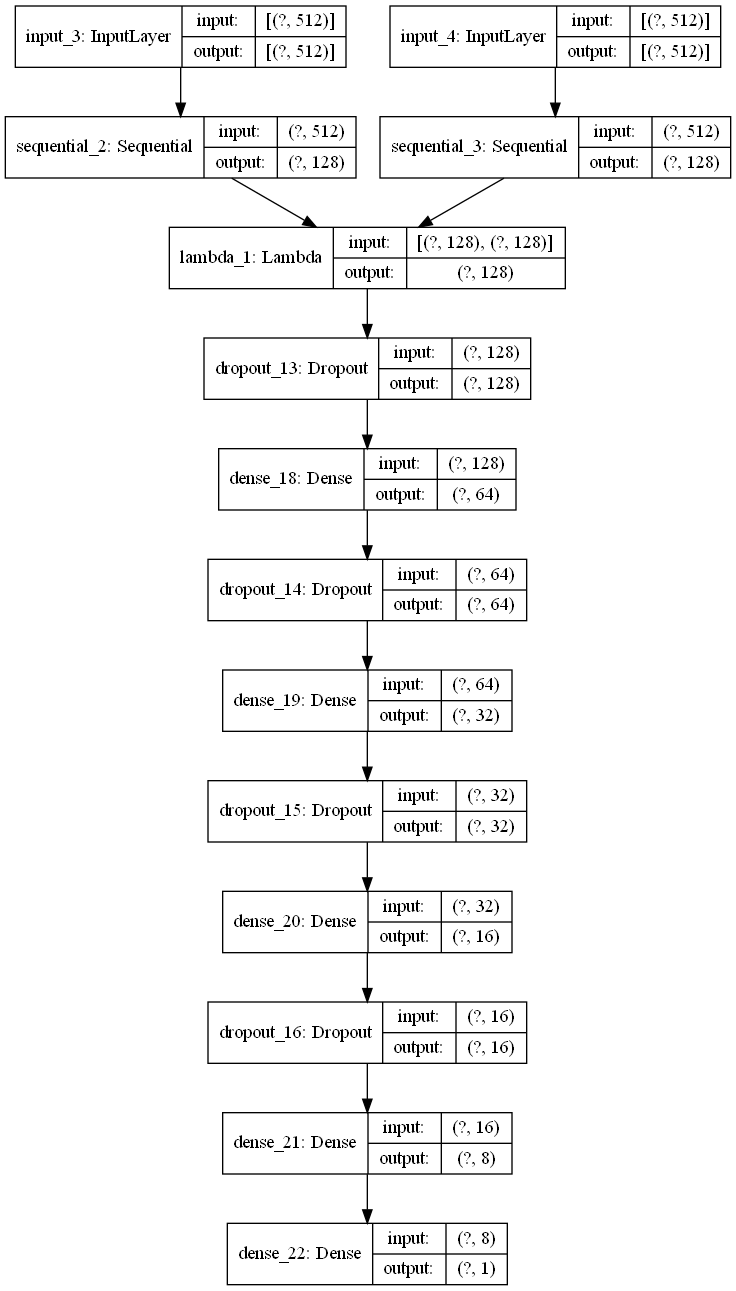

In [43]:
siamese_net = siamese_model_Canonical_sider()

plot_model(siamese_net, show_shapes=True, show_layer_names=True)


### Training algorithm

In [44]:
# models = [siamese_net for task in sider_tasks_final]
Epoch_S = 15
l = []
r = []
lbls = []
for i , data in enumerate(train_dataset):
    smiles, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
    l.append(embbed_drug[0])
    r.append(embbed_task)
    lbls.append(lbl.tolist())

l = np.array(l).reshape(-1,512,1)
r = np.array(r).reshape(-1,512,1)
lbls=np.array(lbls)

history = History()

P = siamese_net.fit([l, r], lbls, epochs = Epoch_S, shuffle=True, batch_size=128, callbacks=[history])

for j in range(1000):
    C=1
    Before = int(P.history['accuracy'][-1]*100)
    for i in range(2,Epoch_S+1):
        if  int(P.history['accuracy'][-i]*100)== Before:
            C=C+1
        else:
            C=1
        Before=int(P.history['accuracy'][-i]*100)
        print(Before)
    if C==Epoch_S:
        break
    P = siamese_net.fit([l, r], lbls, epochs = Epoch_S, shuffle=True, batch_size=128, callbacks=history)
print(j+1)


Epoch 1/15
235/235 [==============================] - 1s 5ms/step - loss: 0.5371 - accuracy: 0.7464 - mae: 0.3558 - mse: 0.1777 - auc_1: 0.8026
Epoch 2/15
235/235 [==============================] - 1s 5ms/step - loss: 0.4952 - accuracy: 0.7785 - mae: 0.3246 - mse: 0.1615 - auc_1: 0.8353
Epoch 3/15
235/235 [==============================] - 1s 5ms/step - loss: 0.4847 - accuracy: 0.7785 - mae: 0.3177 - mse: 0.1579 - auc_1: 0.8429
Epoch 4/15
235/235 [==============================] - 1s 5ms/step - loss: 0.4767 - accuracy: 0.7866 - mae: 0.3109 - mse: 0.1545 - auc_1: 0.8485
Epoch 5/15
235/235 [==============================] - 1s 5ms/step - loss: 0.4728 - accuracy: 0.7858 - mae: 0.3069 - mse: 0.1529 - auc_1: 0.8521
Epoch 6/15
235/235 [==============================] - 1s 5ms/step - loss: 0.4684 - accuracy: 0.7876 - mae: 0.3056 - mse: 0.1517 - auc_1: 0.8546
Epoch 7/15
235/235 [==============================] - 1s 5ms/step - loss: 0.4642 - accuracy: 0.7896 - mae: 0.3026 - mse: 0.1501 - auc_1:

### Model evaluation

In [45]:
valid_ds = {}

for i, task in enumerate(sider_tasks_test):
    temp = []
    for j , data in enumerate(valid_dataset):
        smiles, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
        if task ==  task_name:
            temp.append(data)
    
    valid_ds[task] = temp

In [46]:
task_scores = [sider_tasks_test for sider_tasks_test in range(len(sider_tasks_test))]

for i, task in enumerate(sider_tasks_test):
    print(task,": ")

    y_test = []
    l_val = []
    r_val = []
    lbls_valid = []
    for data in valid_ds[task]:
       
        smiles, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
        l_val.append(embbed_drug[0])
        r_val.append(embbed_task)
        lbls_valid.append(lbl)
            
    l1 = np.array(l_val)
    r1 = np.array(r_val)
    lbls_valid = np.array(lbls_valid)

    score = siamese_net.evaluate([l1,r1],lbls_valid)
 
    result =(score[1], score[4])
    task_scores[i] = task,result

Renal and urinary disorders : 
45/45 [==============================] - 0s 845us/step - loss: 0.4963 - accuracy: 0.7491 - mae: 0.2939 - mse: 0.1625 - auc_1: 0.8426
Pregnancy, puerperium and perinatal conditions : 
45/45 [==============================] - 0s 867us/step - loss: 0.8834 - accuracy: 0.4723 - mae: 0.4900 - mse: 0.3014 - auc_1: 0.7537
Ear and labyrinth disorders : 
45/45 [==============================] - 0s 823us/step - loss: 0.6332 - accuracy: 0.6797 - mae: 0.3536 - mse: 0.2070 - auc_1: 0.8442
Cardiac disorders : 
45/45 [==============================] - 0s 823us/step - loss: 0.4004 - accuracy: 0.8157 - mae: 0.2556 - mse: 0.1274 - auc_1: 0.8788
Nervous system disorders : 
45/45 [==============================] - 0s 801us/step - loss: 0.2161 - accuracy: 0.9201 - mae: 0.1468 - mse: 0.0646 - auc_1: 0.8967
Injury, poisoning and procedural complications : 
45/45 [==============================] - 0s 823us/step - loss: 0.5174 - accuracy: 0.7540 - mae: 0.3019 - mse: 0.1667 - auc_1